<a href="https://colab.research.google.com/github/ehsan-lari/pyro101/blob/main/pyro_07_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Auto Encoder (VAE)
---

In [45]:
!pip install -q --upgrade pyro-ppl

In [46]:
import numpy as np
import torch
import torchvision.datasets as datasets
import torch.nn as nn
import torchvision.transforms as transforms
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import datetime
import os
import matplotlib.gridspec as gridspec
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import norm
import copy
import seaborn as sns
import pandas as pd

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import warnings
warnings.filterwarnings("ignore")

In [47]:
torch.random.manual_seed(42)

def get_data_sample(digits = [1, 2, 3], image_per_class = 100):

  mnist = datasets.MNIST(root='./data/', train=True, download=True)

  select = np.array([], dtype=int)
  for i in digits:
    select = np.concatenate((select,
                             np.random.choice(np.where(mnist.targets == i)[0],
                                              size=image_per_class,
                                              replace=False)))

  mnist.data[mnist.data <= 128] = 0
  mnist.data[mnist.data > 128] = 1

  mnist.data = mnist.data[select,:,:].type(torch.float)
  mnist.targets = mnist.targets[select].reshape(image_per_class*len(digits), -1)

  return mnist

In [48]:
data = get_data_sample()

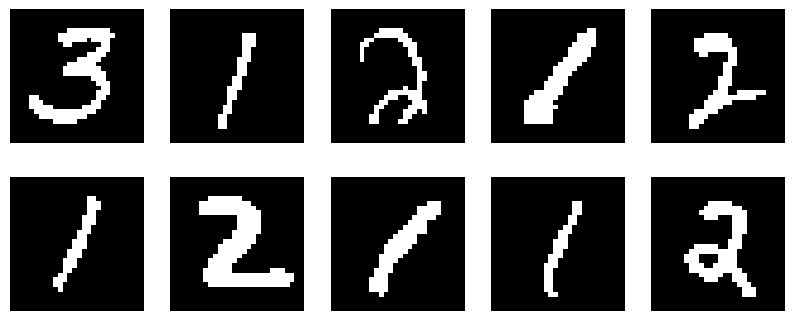

In [50]:
def display_image(x):
    plt.figure(figsize=(10,4))
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(x[i].reshape((28, 28)), cmap="gray")
        # plt.title(x[i].targets)
        plt.axis('off')

toy_image = data.data[np.random.random_integers(0,300,10),:]
display_image(toy_image)

In [51]:
class VAE(nn.Module):
    def __init__(self, z_dim, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.z_dim = z_dim

    def model(self, x):
      pyro.module("decoder", self.decoder)
      with pyro.plate("data", x.shape[0]):
          z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
          z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
          z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
          loc_img = self.decoder.forward(z)
          pyro.sample('obs', dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))

    def guide(self, x):
      pyro.module("encoder", self.encoder)
      with pyro.plate("data", x.shape[0]):
          z_loc, z_scale  = self.encoder.forward(x)
          pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    def sample_images(self, z, num_images = 5):
      if type(z) is not torch.Tensor:
        z = torch.tensor(z, dtype=torch.float32)
      logits = self.decoder.forward(z)
      distribution = dist.Bernoulli(logits=logits)

      f, ax = plt.subplots(1 , num_images+1, figsize=(10, 10), sharex=True)
      plt.axis('off')
      ax[0].imshow(distribution.mean.detach().numpy().reshape(28, 28), cmap='gray')
      ax[0].set_xlabel('Mean of Distribution')
      for i in range(num_images+1):
        ax[i].imshow(distribution.sample().detach().numpy().reshape(28, 28), cmap='gray')
        ax[i].set_xlabel(f"Sample {i+1}")
      plt.show()

    def reconstruct_image(self, x):
      pyro.module("encoder", self.encoder)
      pyro.module("decoder", self.decoder)